In [10]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
base_dir = '/home/fhd/projects/frelnc/signal/cnnmodel/data/'
rec_path = os.path.join(base_dir,'Patient_03_zool2_links.asc')

In [92]:
#defining necessary functions
def read_single(rec_path:str,Left=True) -> pd.DataFrame:
    f = open(rec_path,'r').readlines()
    f=[i.strip() for i in f][10:]
    f=[i.split('\t') for i in f]
    df = pd.DataFrame(f).drop(0,axis=1)

    df=df.astype(float)
    if Left:
        df= df[[i for i in range(1,100)]]
    else:
        df= df[[i for i in range(100,199)]]

    for i in range(len(df)):
        if df.loc[i].any()==0:
            df = df.drop(i,axis=0)
    df = df.reset_index().drop('index',axis=1)
    return df

def read_all(path:str) -> pd.DataFrame:
    df= pd.DataFrame()
    for file in os.listdir(path):
        if file.endswith('asc'):
            df = df.append(read_single(os.path.join(path,file)))
    return df.reset_index().drop('index',axis=1)

def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(12,)))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dense(99,activation='linear'))
    model.compile(optimizer='adam', loss='mse',metrics=['MeanSquaredError',])
    return model

def animate(result,name):
    import matplotlib.pyplot as plt
    from celluloid import Camera
    fig = plt.figure(figsize=(3,6))
    camera = Camera(fig)
    for i in range (result.shape[2]):
        plt.contourf(result[:,:,i],cmap='Reds')
        plt.title(i)
        if i:
            camera.snap()
    animation = camera.animate()
    animation.save(os.path.join('output',name),fps=70)

def convert_2dIndex_to_1d(index):
    shape = (35,20)
    x,y = index
    _,Y = shape
    return x*Y+y

def read_input(INPUT):
    x_input,y_input,p=[],[],[]
    with open(INPUT, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            x_input.append(row[0])
            y_input.append(row[1])
            p.append(row[2])
        f.close()
    x_input = np.array(x_input[1:],dtype=float)
    y_input = np.array(y_input[1:],dtype=float)
    p = np.array(p[1:],dtype=float)
    return x_input,y_input,p

def animate(x:np.array,y:np.array,result:pd.DataFrame,name:str,max=300,):
    import matplotlib.pyplot as plt
    from celluloid import Camera
    fig = plt.figure(figsize=(3,6))
    camera = Camera(fig)
    for i in range(len(result)):
        plt.tricontourf(x,y,result.loc[i],cmap='Reds')
        plt.title(i)
        if i:
            camera.snap()
        if i==max: break
    animation = camera.animate()
    animation.save(os.path.join('output',name),fps=70)

def calculate_dist(pointa,pointb):
    xa,ya=pointa
    xb,yb=pointb
    return ((xa-xb)**2 + (ya-yb)**2)**0.5

def find_nearest(array, point):
    idx = np.asarray([calculate_dist(cordinate,point) for cordinate in cordinates]).argmin()
    return array[idx]

In [98]:
Y = read_all(base_dir)
x,y,_ = read_input('/home/fhd/projects/frelnc/signal/compress1/input.csv')
cordinates = [(i,j) for i,j in zip (x,y)]

In [99]:
selected_nodes_2d =[(4.99,3.3),(3.66,3.3),(6.32,3.3),(4.99,4.6), #posterior
                    (7.6,12.4),(7.6,11.1),(6.2,11.1),           #Lateral
                    (4.68,12.4),                                #Median
                    (8.58,17.6),                                #AntroLateral
                    (1,18.9),                                   #AntroMedial
                    (1.55, 15.0),(3.1, 15.0),                   #Medial
                    ]                      
                    
selected_nodes_1d = list(map(lambda x : cordinates.index(x),selected_nodes_2d))
X = Y[selected_nodes_1d]

In [100]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, shuffle =False)

In [ ]:
model = create_model()

2022-01-22 20:00:13.233469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 20:00:13.233522: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 20:00:13.233541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Fhd): /proc/driver/nvidia/version does not exist
2022-01-22 20:00:13.234475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [102]:
model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=5,
    validation_split=0.2, validation_data=None, shuffle=True,
    workers=2, use_multiprocessing=True
)

Epoch 1/5
8/8 [==============================] - 1s 25ms/step - loss: 2776.0190 - mean_squared_error: 2776.0190 - val_loss: 2650.4436 - val_mean_squared_error: 2650.4436
Epoch 2/5
8/8 [==============================] - 0s 5ms/step - loss: 2549.4783 - mean_squared_error: 2549.4783 - val_loss: 2378.5698 - val_mean_squared_error: 2378.5698
Epoch 3/5
8/8 [==============================] - 0s 6ms/step - loss: 2256.3145 - mean_squared_error: 2256.3145 - val_loss: 2022.2379 - val_mean_squared_error: 2022.2379
Epoch 4/5
8/8 [==============================] - 0s 6ms/step - loss: 1887.0228 - mean_squared_error: 1887.0228 - val_loss: 1622.0521 - val_mean_squared_error: 1622.0521
Epoch 5/5
8/8 [==============================] - 0s 7ms/step - loss: 1517.6788 - mean_squared_error: 1517.6788 - val_loss: 1280.8752 - val_mean_squared_error: 1280.8752


In [103]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 0s 1ms/step - loss: 1409.8746 - mean_squared_error: 1409.8746


[1409.8746337890625, 1409.8746337890625]

In [75]:
test = read_single('path')
test_x = test[selected_nodes_1d]
result = model.predict(test_x)
model.save('model99.hdf5')

8

In [ ]:
animate(x,y,result,'99predicted-bymodelV0.0.gif')

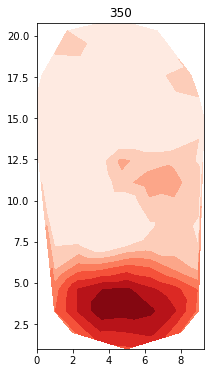

In [39]:
animate(x,y,Y,'99sens.gif',max=350)